In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Covid-detection/COUGH-SOUND-COV-DETECTION

/content/drive/MyDrive/Colab Notebooks/Covid-detection/COUGH-SOUND-COV-DETECTION


In [ ]:
import librosa
import librosa.display

In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from keras.applications import ResNet50
from sklearn.metrics import accuracy_score, confusion_matrix

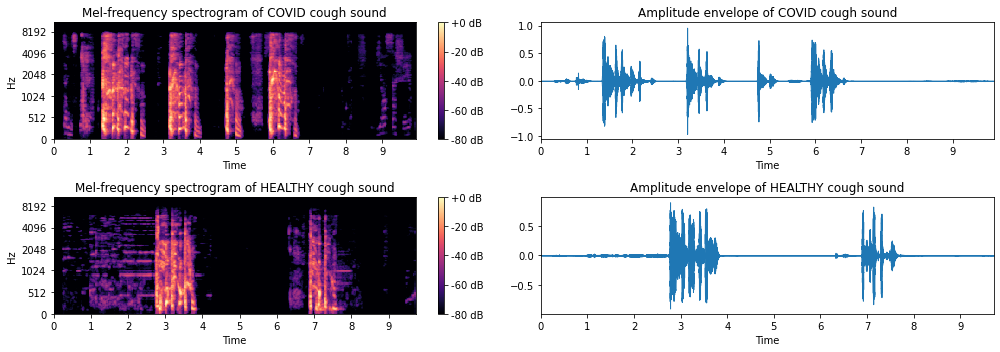

In [ ]:
audio_file = 'train/COVID/0d1cb244-e3cb-404d-97f5-99592b92da44.wav'

samples, sr = librosa.load(audio_file) #sr= sampling rate

#Generate the mel spectogram
audioSpec = librosa.feature.melspectrogram(samples)

#Convert to db scale
audio_dB = librosa.power_to_db(audioSpec,ref=np.max)

fig, ax = plt.subplots(2,2, figsize = (14,5))

# Plot the Mel spectrogram
img = librosa.display.specshow(audio_dB, x_axis='time',y_axis='mel', sr=sr,ax=ax[0,0])
fig.colorbar(img, ax=ax[0,0], format='%+2.0f dB')
ax[0,0].set(title='Mel-frequency spectrogram of COVID cough sound')

#Plot the amplitude envelope of the waveform
ax[0,1].set(title= 'Amplitude envelope of COVID cough sound')
librosa.display.waveplot(samples,ax=ax[0,1])

audio_file = 'train/HEALTHY/0aa87162-2ae6-441d-8966-981d76105898.wav'

samples, sr = librosa.load(audio_file) #sr= sampling rate

#Generate the mel spectogram
audioSpec = librosa.feature.melspectrogram(samples)

#Convert to db scale
audio_dB = librosa.power_to_db(audioSpec,ref=np.max)

# Plot the Mel spectrogram
img = librosa.display.specshow(audio_dB, x_axis='time',y_axis='mel', sr=sr,ax=ax[1,0])
fig.colorbar(img, ax=ax[1,0], format='%+2.0f dB')
ax[1,0].set(title='Mel-frequency spectrogram of HEALTHY cough sound')

#Plot the amplitude envelope of the waveform
ax[1,1].set(title= 'Amplitude envelope of HEALTHY cough sound')
librosa.display.waveplot(samples,ax=ax[1,1])

fig.tight_layout()
plt.show()


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Covid-detection/COUGH-SOUND-COV-DETECTION'

sets = ['train','test','val']

train_X, train_X_image, train_Y = ([], [], [])
test_X, test_X_image, test_Y = ([], [], [])
val_X, val_X_image, val_Y = ([], [], [])

data = [(train_X, train_X_image, train_Y), (test_X, test_X_image, test_Y), (val_X, val_X_image, val_Y)]

counter=0

# Loop through all splits
for s,d in (zip(sets,data)):
    path_to_cat = os.path.join(path, s)
    
    # Loop through categories in split
    for cat in os.listdir(path_to_cat):

        if cat=='COVID':
            label=0
        else:
            label=1

        path_to_audio_files = os.path.join(path_to_cat, cat)

        for i in os.listdir(path_to_audio_files):
            audio_file = os.path.join(path_to_audio_files, i)

            samples, sr = librosa.load(audio_file)

            if 2048 > audio.shape[-1]: #n_fft = 2048
                os.remove(audio_file)
                continue

            #Extract 13 MFCC features
            mfccs = librosa.feature.mfcc(samples,n_mfcc=13,sr=sr)

            #Generate the mel spectogram
            audioSpec = librosa.feature.melspectrogram(audio)

            Convert to db scale
            audio_db = librosa.power_to_db(audioSpec,ref=np.max)

            fig,ax = plt.subplots(1)
            fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
            ax.axis('tight')
            ax.axis('off')
            img = librosa.display.specshow(audio_db)
            img_path = 'NEW_IMAGES/'+s+'/'+cat+'/'+str(counter)+'.png'
            fig.savefig(img_path)
            counter += 1
            plt.close(fig)

            image = cv.imread(img_path)
            image = cv.resize(image,(224,224))

            d[0].append(mfccs) #mfcc features
            d[1].append(image) #mel spectogram
            d[2].append(label) #labels 0-> covid 1-> healthy

In [ ]:
print(len(train_X),len(train_X_image),len(train_Y),len(test_X),len(test_X_image),len(test_Y),len(val_X),len(val_X_image),len(val_Y))

2017 2017 2017 252 252 252 252 252 252


In [ ]:
import tensorflow
import keras
from tensorflow.keras.layers import Dense, Input, Concatenate ,GlobalMaxPooling2D , GlobalAveragePooling2D ,BatchNormalization,Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [ ]:
baseModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

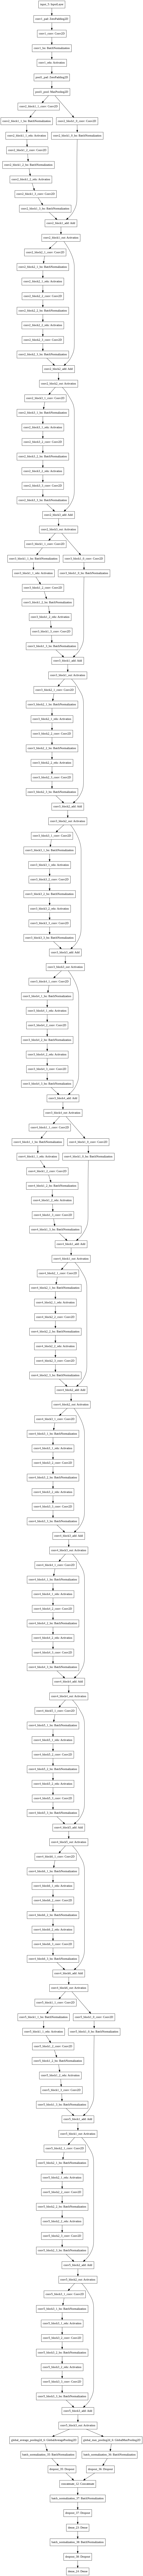

In [ ]:
input_1 = Input(shape=(13,))

x_1 = Dense(256, activation="relu")(input_1)
x_1 = BatchNormalization(axis=1)(x_1)
x_1 = Dropout(rate=0.5)(x_1)
x_1 = Dense(256, activation="relu")(x_1)
x_1 = BatchNormalization(axis=1)(x_1)
x_1 = Dropout(rate=0.5)(x_1)

x_2 = Dense(64, activation="relu")(input_1)
x_2 = BatchNormalization(axis=1)(x_2)
x_2 = Dropout(rate=0.5)(x_2)
x_2 = Dense(64, activation="relu")(x_2)
x_2 = BatchNormalization(axis=1)(x_2)
x_2 = Dropout(rate=0.5)(x_2)

merged_1 = Concatenate(axis=-1)([x_1,x_2])

resnet_output = baseModel.output
branch_1 = GlobalAveragePooling2D()(resnet_output)
branch_1 = BatchNormalization(axis=1)(branch_1)
branch_1 = Dropout(rate=0.5)(branch_1)

branch_2 = GlobalMaxPooling2D()(resnet_output)
branch_2 = BatchNormalization(axis=1)(branch_2)
branch_2 = Dropout(rate=0.5)(branch_2)

merged_2 = Concatenate(axis=-1)([branch_1, branch_2])

merged_2 = BatchNormalization(axis=1)(merged_2)
merged_2 = Dropout(rate=0.5)(merged_2)

merged = Concatenate(axis=-1)([merged_1,merged_2])

out = Dense(256, activation="relu")(merged)
out = BatchNormalization(axis=1)(out)
out = Dropout(rate=0.5)(out)
out = Dense(1, activation="sigmoid")(out)

model = Model(inputs=[input_1,baseModel.input], outputs=out)
model.summary()
plot_model(model,'model.png')

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.001)

In [ ]:
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
trainx_images = np.array(train_X_image)/255.0
trainy = np.array(train_Y)

testx_images = np.array(test_X_image)/255.0
testy = np.array(test_Y)

valx_images = np.array(val_X_image)/255.0
valy = np.array(val_Y)

In [ ]:
def find_mean(x):
    return np.mean(x)

In [ ]:
trainx = []

for i in train_X:
    val=np.apply_along_axis(find_mean,axis=1,arr=i)
    trainx.append(val)

In [ ]:
trainx =  np.array(trainx)

In [ ]:
valx = []

for i in val_X:
    val=np.apply_along_axis(find_mean,axis=1,arr=i)
    valx.append(val)

In [ ]:
valx = np.array(valx)

In [ ]:
trainx.shape

(2017, 13)

In [ ]:
history = model.fit(x=[trainx, trainx_images], y=trainy ,validation_data=([valx, valx_images], valy),epochs=12)

In [ ]:
testx = []

for i in test_X:
    val=np.apply_along_axis(find_mean,axis=1,arr=i)
    testx.append(val)

In [ ]:
testx = np.array(testx)

In [ ]:
pred = model.predict([testx, testx_images])

In [ ]:
predictions = []
for i in pred:
  if i>0.5:
    predictions.append(1)
  else:
    predictions.append(0)

predictions = np.array(predictions)

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(testy, predictions)
print("ACCURACY : ",acc)

ACCURACY :  0.6666666666666666


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(testy, predictions)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.78      0.46      0.58       126
           1       0.62      0.87      0.72       126

    accuracy                           0.67       252
   macro avg       0.70      0.67      0.65       252
weighted avg       0.70      0.67      0.65       252



In [ ]:
#model.save('cough_sound_pred_model2.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


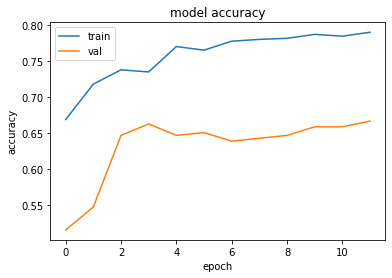

In [ ]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

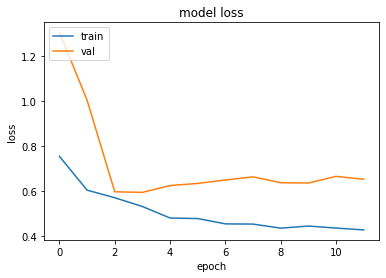

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Reference : https://arxiv.org/abs/2103.01806v2